In [916]:
cd ~/data/modl_data/pipeline/contrast/prediction/654/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/654


In [917]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [918]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)


def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [919]:
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

coef = estimator.named_steps['logistic_regression'].coef_
intercept = estimator.named_steps['logistic_regression'].intercept_
pipeline = Pipeline(estimator.steps[:-1])

In [920]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [921]:
pipeline.named_steps['feature_importance'].feature_importance[:] = 1
maps = pipeline.inverse_transform(coef)

mask = fetch_hcp(n_subjects=1).mask
masker = MultiNiftiMasker(mask_img=mask).fit()
imgs = masker.inverse_transform(maps)

print('Shape', imgs.shape)

Shape (91, 109, 91, 30)


In [922]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [923]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_archi_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [924]:
from sklearn.metrics import confusion_matrix

In [925]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

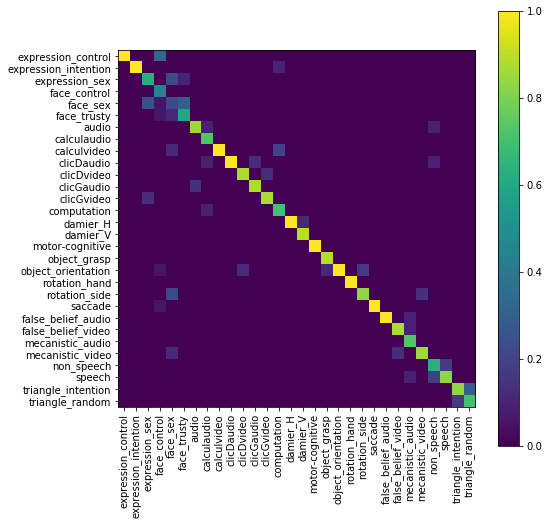

In [926]:
plot_confusion_matrix(test_conf, labels)

In [927]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task       contrast            
archi    emotional  expression_control      0.250
                    expression_intention    0.875
                    expression_sex          0.625
                    face_control            1.000
                    face_sex                0.250
                    face_trusty             0.750
         localizer  audio                   0.750
                    calculaudio             1.000
                    calculvideo             0.625
                    clicDaudio              0.625
                    clicDvideo              0.875
                    clicGaudio              0.875
                    clicGvideo              0.875
                    computation             0.875
                    damier_H                0.875
                    damier_V                1.000
                    motor-cognitive         1.000
         parietal   object_grasp            1.000
                    object_orientation      0.500
         

In [928]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.787500
train  archi      0.997619
Name: match, dtype: float64

In [929]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = le.transform(labels_archi)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [834]:
indices = le.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

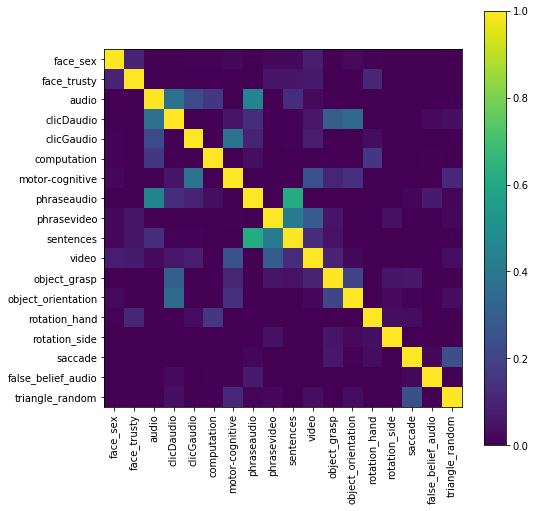

In [741]:
G = ncoef.dot(ncoef.T)
G[G < 0] = 0
plot_gram_matrix(G, labels)

In [702]:
(np.abs(coef[indices,:16]).sum())

198.94312083593474

In [703]:
(np.abs(coef[indices,16:80])).sum()

658.59422484354991

In [704]:
np.abs(coef[indices,80:80 + 256]).sum()

1519.6304241964042

In [705]:
np.mean(coef[indices, :16] == 0)

0.40277777777777779

In [706]:
np.mean(coef[indices, 16:80] == 0)

0.66666666666666663

In [707]:
np.mean(coef[indices, 80:256] == 0)

0.91082702020202022